## TOC:
   1. [Load the Modules](#first-bullet)
   2. [Load, Examine and Explore the Data](#second-bullet)
   3. [Plotting some Example](#second1-bullet)
   4. [Creating model](#4-bullet)
   5. [Training the model](#5-bullet)
   6. [Visualizing Loss and Accuracy](#6-bullet)
   7. [Predictings Image](#7-bullet)

# 1. Load the Modules <a class="anchor" id="first-bullet"></a>

In [9]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 2. Load the Data, Examine and Explore <a class="anchor" id="second-bullet"></a>

In [10]:
batch_size = 32
img_height = 180
img_width = 180

In [11]:
data_dir = pathlib.Path('/datasets/utk-face/')
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

23708


In [12]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*.jpg'))
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [13]:
for f in list_ds.take(5):
    print(f.numpy())

b'/datasets/utk-face/58_0_0_20170111205019096.jpg.chip.jpg'
b'/datasets/utk-face/54_1_0_20170117171412187.jpg.chip.jpg'
b'/datasets/utk-face/24_0_0_20170109214744250.jpg.chip.jpg'
b'/datasets/utk-face/28_1_0_20170117020138207.jpg.chip.jpg'
b'/datasets/utk-face/35_0_0_20170120221029196.jpg.chip.jpg'


In [14]:
class_meaning = {
    0: 'female',
    1: 'male'
}
class_names = np.array([0, 1])
print(class_names)

[0 1]


In [15]:
val_size = int(image_count * 0.0001)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

23706
2


In [16]:
# Functions to load and process images

def get_label(file_path):
    file = tf.strings.split(file_path, os.path.sep)[-1]
    label = tf.strings.split(file, '_')[1]
    label = tf.strings.to_number(label, tf.int32)
    return label

def read_n_decode_img(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    img = read_n_decode_img(file_path)
    return img, label

def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [17]:
print(type(train_ds))
print(type(val_ds))

<class 'tensorflow.python.data.ops.dataset_ops.SkipDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>


In [18]:
train_ds = train_ds.map(
    process_path,
    num_parallel_calls=tf.data.AUTOTUNE
)
val_ds = val_ds.map(
    process_path,
    num_parallel_calls=tf.data.AUTOTUNE
)

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

# 3. Plotting some Examples <a class="anchor" id="second1-bullet"></a>

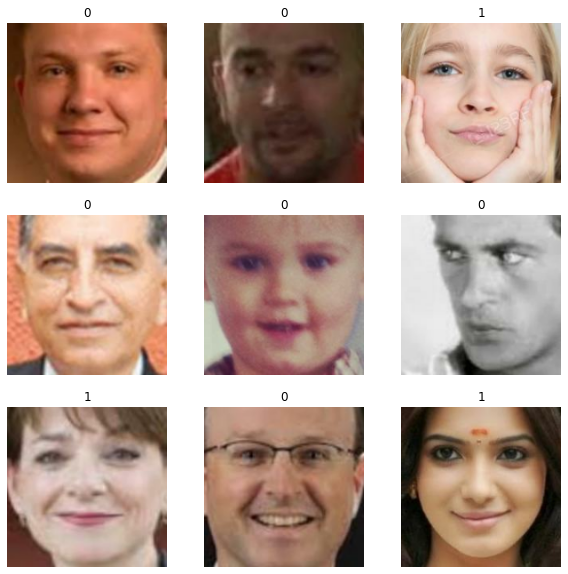

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy())
        plt.axis("off")

In [20]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


# 4. Creating model <a class="anchor" id="4-bullet"></a>
Here we're using Convolutional Neural Network (CNN)

In [21]:
# Data Augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

In [22]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  data_augmentation,
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation = "sigmoid")
])

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 5. Training the model <a class="anchor" id="5-bullet"></a>

In [24]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
741/741 [==============================] - 45s 56ms/step - loss: 0.6594 - accuracy: 0.6526 - val_loss: 0.6737 - val_accuracy: 0.5000
Epoch 2/20
741/741 [==============================] - 45s 60ms/step - loss: 0.6062 - accuracy: 0.6602 - val_loss: 0.3684 - val_accuracy: 1.0000
Epoch 3/20
741/741 [==============================] - 43s 56ms/step - loss: 0.5612 - accuracy: 0.7140 - val_loss: 0.3738 - val_accuracy: 1.0000
Epoch 4/20
741/741 [==============================] - 44s 58ms/step - loss: 0.6213 - accuracy: 0.6209 - val_loss: 0.3779 - val_accuracy: 1.0000
Epoch 5/20
741/741 [==============================] - 44s 58ms/step - loss: 0.5434 - accuracy: 0.7269 - val_loss: 0.2899 - val_accuracy: 1.0000
Epoch 6/20
741/741 [==============================] - 44s 59ms/step - loss: 0.5379 - accuracy: 0.7314 - val_loss: 0.5807 - val_accuracy: 0.5000
Epoch 7/20
741/741 [==============================] - 43s 57ms/step - loss: 0.5302 - accuracy: 0.7353 - val_loss: 0.3293 - val_accuracy:

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 89, 89, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 128)       73856     
                                                      

# 6. Visualizing Loss and Accuracy <a class="anchor" id="6-bullet"></a>

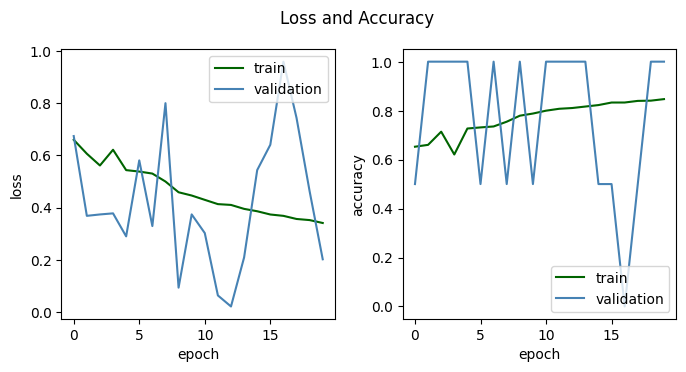

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100)
fig.suptitle('Loss and Accuracy')
fig.tight_layout()
fig.set_size_inches(7, 3.5, forward=True)

ax1.plot(history.history['loss'], color="darkgreen")
ax1.plot(history.history['val_loss'], color="steelblue")
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend(['train', 'validation'], loc='upper right')

ax2.plot(history.history['accuracy'], color="darkgreen")
ax2.plot(history.history['val_accuracy'], color="steelblue")
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend(['train', 'validation'], loc='lower right')

# 7. Predicting Images <a class="anchor" id="7-bullet"></a>

2022-10-07 23:30:02.401548: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at strided_slice_op.cc:102 : INVALID_ARGUMENT: slice index 2 of dimension 0 out of bounds.


InvalidArgumentError: slice index 2 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

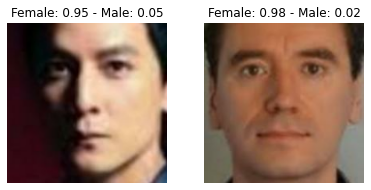

In [27]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        img = images[i].numpy().astype("uint8")
        pred = model.predict(
            img.reshape(1, img_height, img_width, 3),
            verbose=0
        )[0]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Female: {:.2f} - Male: {:.2f}'.format(pred[0], 1 - pred[0]))
        plt.axis("off")

# Conclusión
* As can be seen, around epoch 18, the model begins to stop learning and possibly begins to overfit, this can be treated by making improvements to the model design.

* Another interesting aspect that can be dealt with is the complexity in the prediction of children's faces, which, as can be seen, neither of the two classes has a clear advantage over the other.

In [28]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
